In [668]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import DivergingNorm
import sys
sys.path.insert(1, '../../utils/')
import src_utils
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import scipy

from matplotlib import pyplot as plt
from matplotlib.colors import rgb2hex
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage

import numpy as np
np.set_printoptions(precision=5, suppress=True)

# 1. Set rcParams

In [669]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rcParams['axes.linewidth'] = 0.5

plt.rcParams["figure.dpi"] = 300

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)   # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

# 2. Set up grid

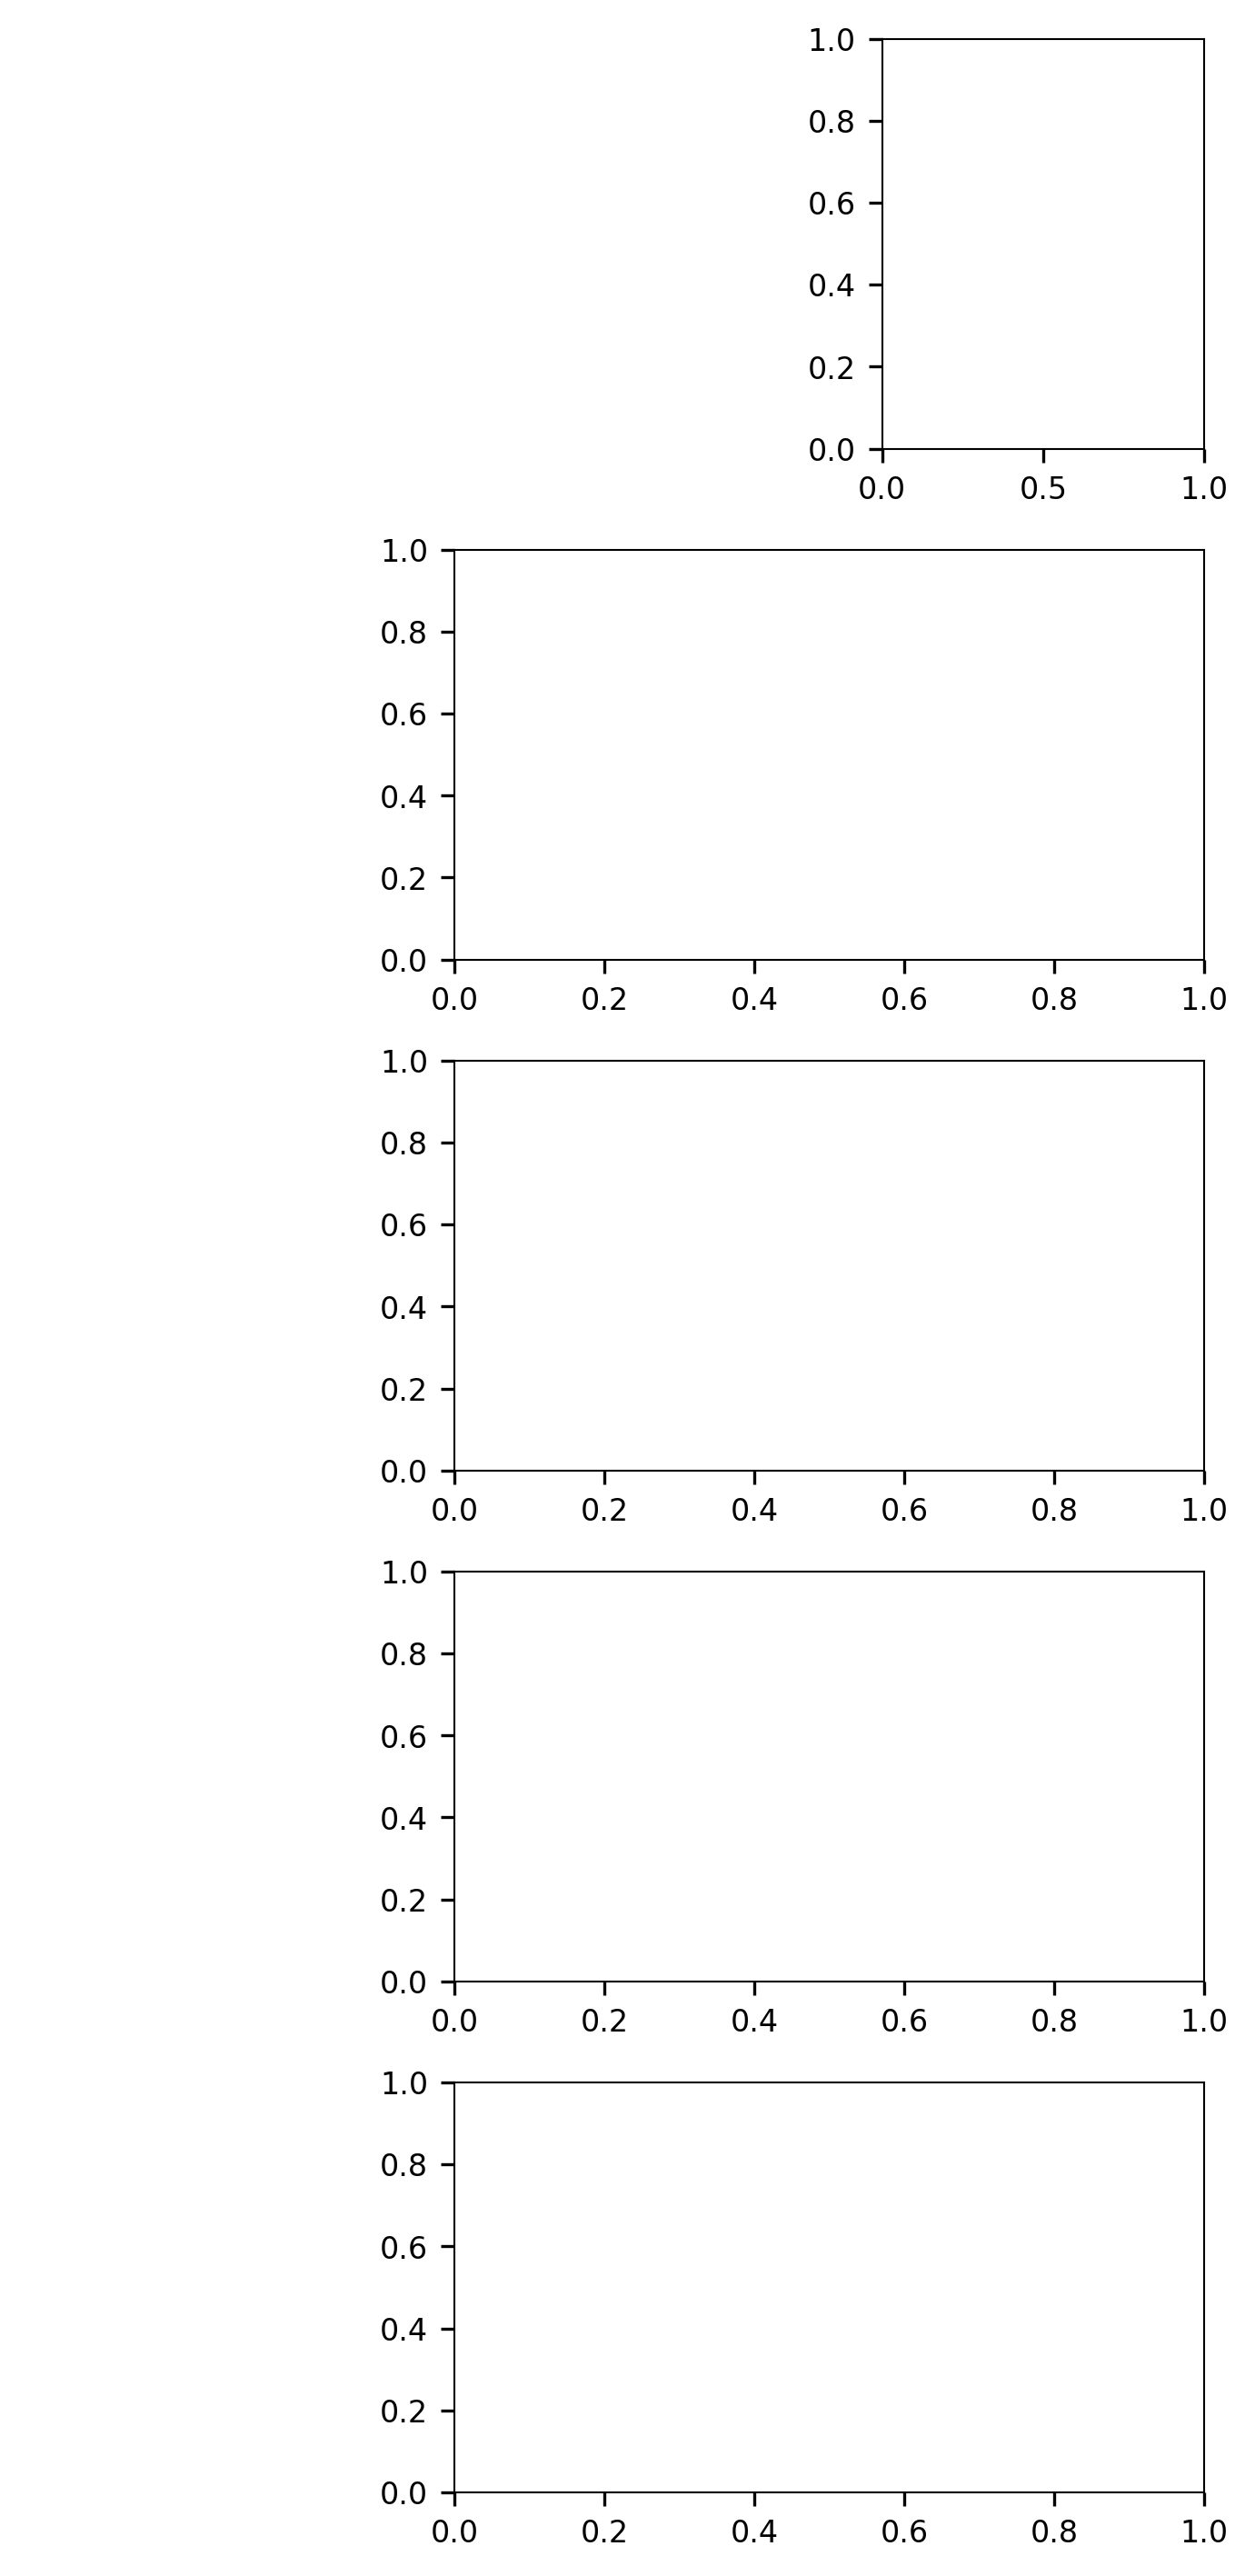

In [670]:
width = 114 / 25.4
height = 237 / 25.4
fig4 = plt.figure(constrained_layout=True, figsize=(width, height))
gs = fig4.add_gridspec(5, 3)
f4_ax1 = fig4.add_subplot(gs[0, 2])
f4_ax2 = fig4.add_subplot(gs[1, 1:])
#f4_ax3 = fig4.add_subplot(gs[1, 2])
f4_ax4 = fig4.add_subplot(gs[2, 1:])
#f4_ax5 = fig4.add_subplot(gs[2, 2])
f4_ax6 = fig4.add_subplot(gs[3, 1:])
#f4_ax7 = fig4.add_subplot(gs[3, 2])
f4_ax8 = fig4.add_subplot(gs[4, 1:])
#f4_ax9 = fig4.add_subplot(gs[4, 2])

# B. Dendrogram

(0.0, 1.0, 0.0, 1.0)

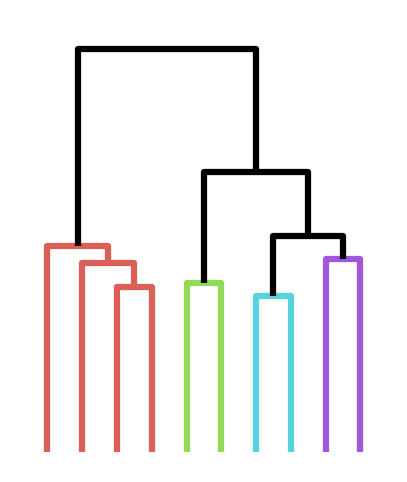

In [671]:
# Heatmap
resid_map = pd.read_csv('../heatmaps/raw_resid_heatmap.csv', index_col=0)

# Masks for clients
clients = np.loadtxt('../../utils/analysis_utils/client_mask.csv').astype(bool)
strong_clients = np.loadtxt('../../utils/analysis_utils/strong_client_mask.csv').astype(bool)
ihb_clients = np.loadtxt('../../utils/analysis_utils/inhibited_clients.csv').astype(bool)
dep_clients = np.loadtxt('../../utils/analysis_utils/dependent_clients.csv').astype(bool)

strong_ihb_clients = strong_clients & ihb_clients
strong_dep_clients = strong_clients & dep_clients

# Fill with 0s and generate the linkage matrix
X = resid_map.fillna(0.0)
Z = linkage(X, 'ward')

# Fancy dendrogram function stolen from the internet
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
        kwargs['above_threshold_color'] = 'k'
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        #plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        #if max_d=
        #    plt.axhline(y=max_d, c='k')
    return ddata

# Get colors to hex format
"""cmap = matplotlib.cm.get_cmap('bwr')
dep = cmap(0.3)
ihb = cmap(0.8)
weak = cmap(0.6)"""
palette = sns.color_palette("hls", 8)
scipy.cluster.hierarchy.set_link_color_palette([rgb2hex(palette[0]), rgb2hex(palette[2]), rgb2hex(palette[4]), rgb2hex(palette[6])])

# Plot on grid
width = 38 / 25.4
height = 47.4 / 25.4
fig, ax = plt.subplots(figsize=(width, height))
plt.sca(ax)
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=10,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
    max_d=5.20
)
ax.axis('off')
f4_ax1.axis('off')

In [672]:
fig.savefig('../../Figures/manuscript_figs/fig4_drafts/dendrogram_v1.png')

# G-J. Dot plots of values to corresponding clusters

In [673]:
# Get clusters
clusters = fcluster(Z, 10, criterion='maxclust')

In [674]:
heatmap.shape

(21, 156)

In [675]:
# Create cluster dictionary with key=cluster, val=idx
clust_dict = {}
for cluster in np.arange(1, max(clusters) + 1):
    clust_dict[cluster] = np.argwhere(clusters == cluster).flatten()
    
# Create cluster masks for indexing from the heatmap
def gen_clust_mask(cluster_arr, cluster, heatmap):
    mask = np.expand_dims(cluster_arr == cluster, axis=1)
    mask = np.repeat(mask, repeats=heatmap.values.shape[1], axis=1)
    return(mask)
clust_masks = {}
for cluster in clust_dict.keys():
    clust_masks[cluster] = gen_clust_mask(clusters, cluster, resid_map)

# Get original cluster values
clust_arr_x = []
clust_arr_y = []
clust_arrs = {}
for cluster in clust_dict.keys():
    clust = clust_dict[cluster]
    mask = clust_masks[cluster]
    heatmap = resid_map.values[mask].reshape(-1, 21).T
    clust_vals = heatmap[~np.isnan(heatmap)]
    clust_arr_x = clust_arr_x + [cluster] * len(clust_vals)
    clust_arr_y = clust_arr_y + list(clust_vals)
    clust_arrs[cluster] = (([cluster] * len(clust_vals)), list(clust_vals))
    
# Define secondary structure elements
ss_elem = {
    r'$\beta1$' : np.arange(270, 279),
    r'$\beta2$' : np.arange(282, 289),
    r'$\beta3$' : np.arange(293, 300),
    r'$\alpha C$' : np.arange(309, 318),
    r'$\beta4$' : np.arange(328, 332),
    r'$\beta5$' : np.arange(338, 342),
    r'$\alpha D$' : np.arange(349, 352),
    r'$\alpha E$' : np.arange(363, 383),
    r'$\beta7$' : np.arange(394, 397),
    r'$\beta8$' : np.arange(403, 405),
    r'$\alpha EF$' : np.arange(433, 439),
    r'$\alpha F$' : np.arange(444, 460),
    r'$\alpha G$' : np.arange(471, 476),
    r'$\alpha H$' : np.arange(492, 502),
    r'$\alpha I$' : np.arange(512, 519),
}

# Create 1D array showing secondary structure
ss_arr = list(np.zeros(250))
for key_idx, elem in enumerate(list(ss_elem.keys())):
    positions = ss_elem[elem]
    for pos in positions:
        idx = src_utils.__pos_idx_dict__[pos]
        ss_arr[idx] = elem
    if key_idx < len(ss_elem.keys()) - 1:
        loop_positions = np.arange(max(positions), min(ss_elem[list(ss_elem.keys())[key_idx + 1]]))
        loop_name = list(ss_elem.keys())[key_idx] + '_' + list(ss_elem.keys())[key_idx + 1] + '_loop'
        for pos in loop_positions:
            idx = src_utils.__pos_idx_dict__[pos]
            #ss_arr[idx] = loop_name
            ss_arr[idx] = 'loop'
ss_arr[-1] = 'ai'

# Match heatmap shape
ss_map = np.expand_dims(ss_arr, axis=1)
ss_map = np.repeat(ss_map, repeats=resid_map.shape[1], axis=1)

# Mask NaNs in secondary structure map
nanmask = np.isnan(resid_map).values
ss_map[nanmask] = np.nan

# Index the same way
clust_arrs = {}
for cluster in clust_dict.keys():
    
    # Get cluster positions and corresponding mask
    clust = clust_dict[cluster]
    mask = clust_masks[cluster]
    
    # Get subset of heatmap from mask and create nonNaN mask
    heatmap = resid_map.values[mask].reshape(-1, 21).T
    ss_submap = ss_map[mask].reshape(-1, 21).T
    val_mask = ~np.isnan(heatmap)
    
    # Index cluster values and secondary structure element categories
    clust_vals = heatmap[val_mask]
    ss_labels = ss_submap[val_mask]
    
    # Append to dictionary
    clust_arrs[cluster] = (ss_labels, clust_vals)

# Create new clustered clusters
clust_clust_dict = {
    1: 1,
    2: 1,
    3: 1,
    4: 1,
    5: 2,
    6: 2,
    7: 3,
    8: 3,
    9: 4,
    10: 4
}
new_clusters = []
for clust_id in clusters:
    new_clusters.append(clust_clust_dict[clust_id])

new_clust_arrs = {}
for cluster in clust_arrs.keys():
    new_cluster = clust_clust_dict[cluster]
    if new_cluster not in new_clust_arrs.keys():
        new_clust_arrs[new_cluster] = clust_arrs[cluster]
    else:
        x = np.concatenate((new_clust_arrs[new_cluster][0], clust_arrs[cluster][0]))
        y = np.concatenate((new_clust_arrs[new_cluster][1], clust_arrs[cluster][1]))
        new_clust_arrs[new_cluster] = (x, y)

# Define colors for dependent and inhibited
def get_hue_assn(values):
    hue_list = []
    std = 0.3244531554065337
    mean = -5.581241140646316e-17
    ihb_thresh = mean + std
    dep_thresh = mean - std
    for value in values:
        if value < dep_thresh:
            hue_level = 'Dependent client'
        elif value < ihb_thresh:
            hue_level = 'Nonclient'
        else:
            hue_level = 'Inhibited client'
        hue_list.append(hue_level)
    return(hue_list)

cmap = matplotlib.cm.get_cmap('bwr')
dep = cmap(0.3)
ihb = cmap(0.8)
hue_palette = {
    'Dependent client' : dep,
    'Nonclient' : 'lightgrey',
    'Inhibited client' : ihb
}

dotplot_axes = [f4_ax2, f4_ax4, f4_ax6, f4_ax8]
for cluster, ax in zip(new_clust_arrs.keys(), dotplot_axes):
    x, y = new_clust_arrs[cluster]
    hues = get_hue_assn(y)
    sns.stripplot(x, y, linewidth=1, hue=hues, palette=hue_palette, ax=ax)
    ax.get_legend().remove()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)    
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

    #plt.title(str(cluster))
    #plt.legend(labels=('Dependent client', 'Nonclient', 'Inhibited client'))
    plt.show()

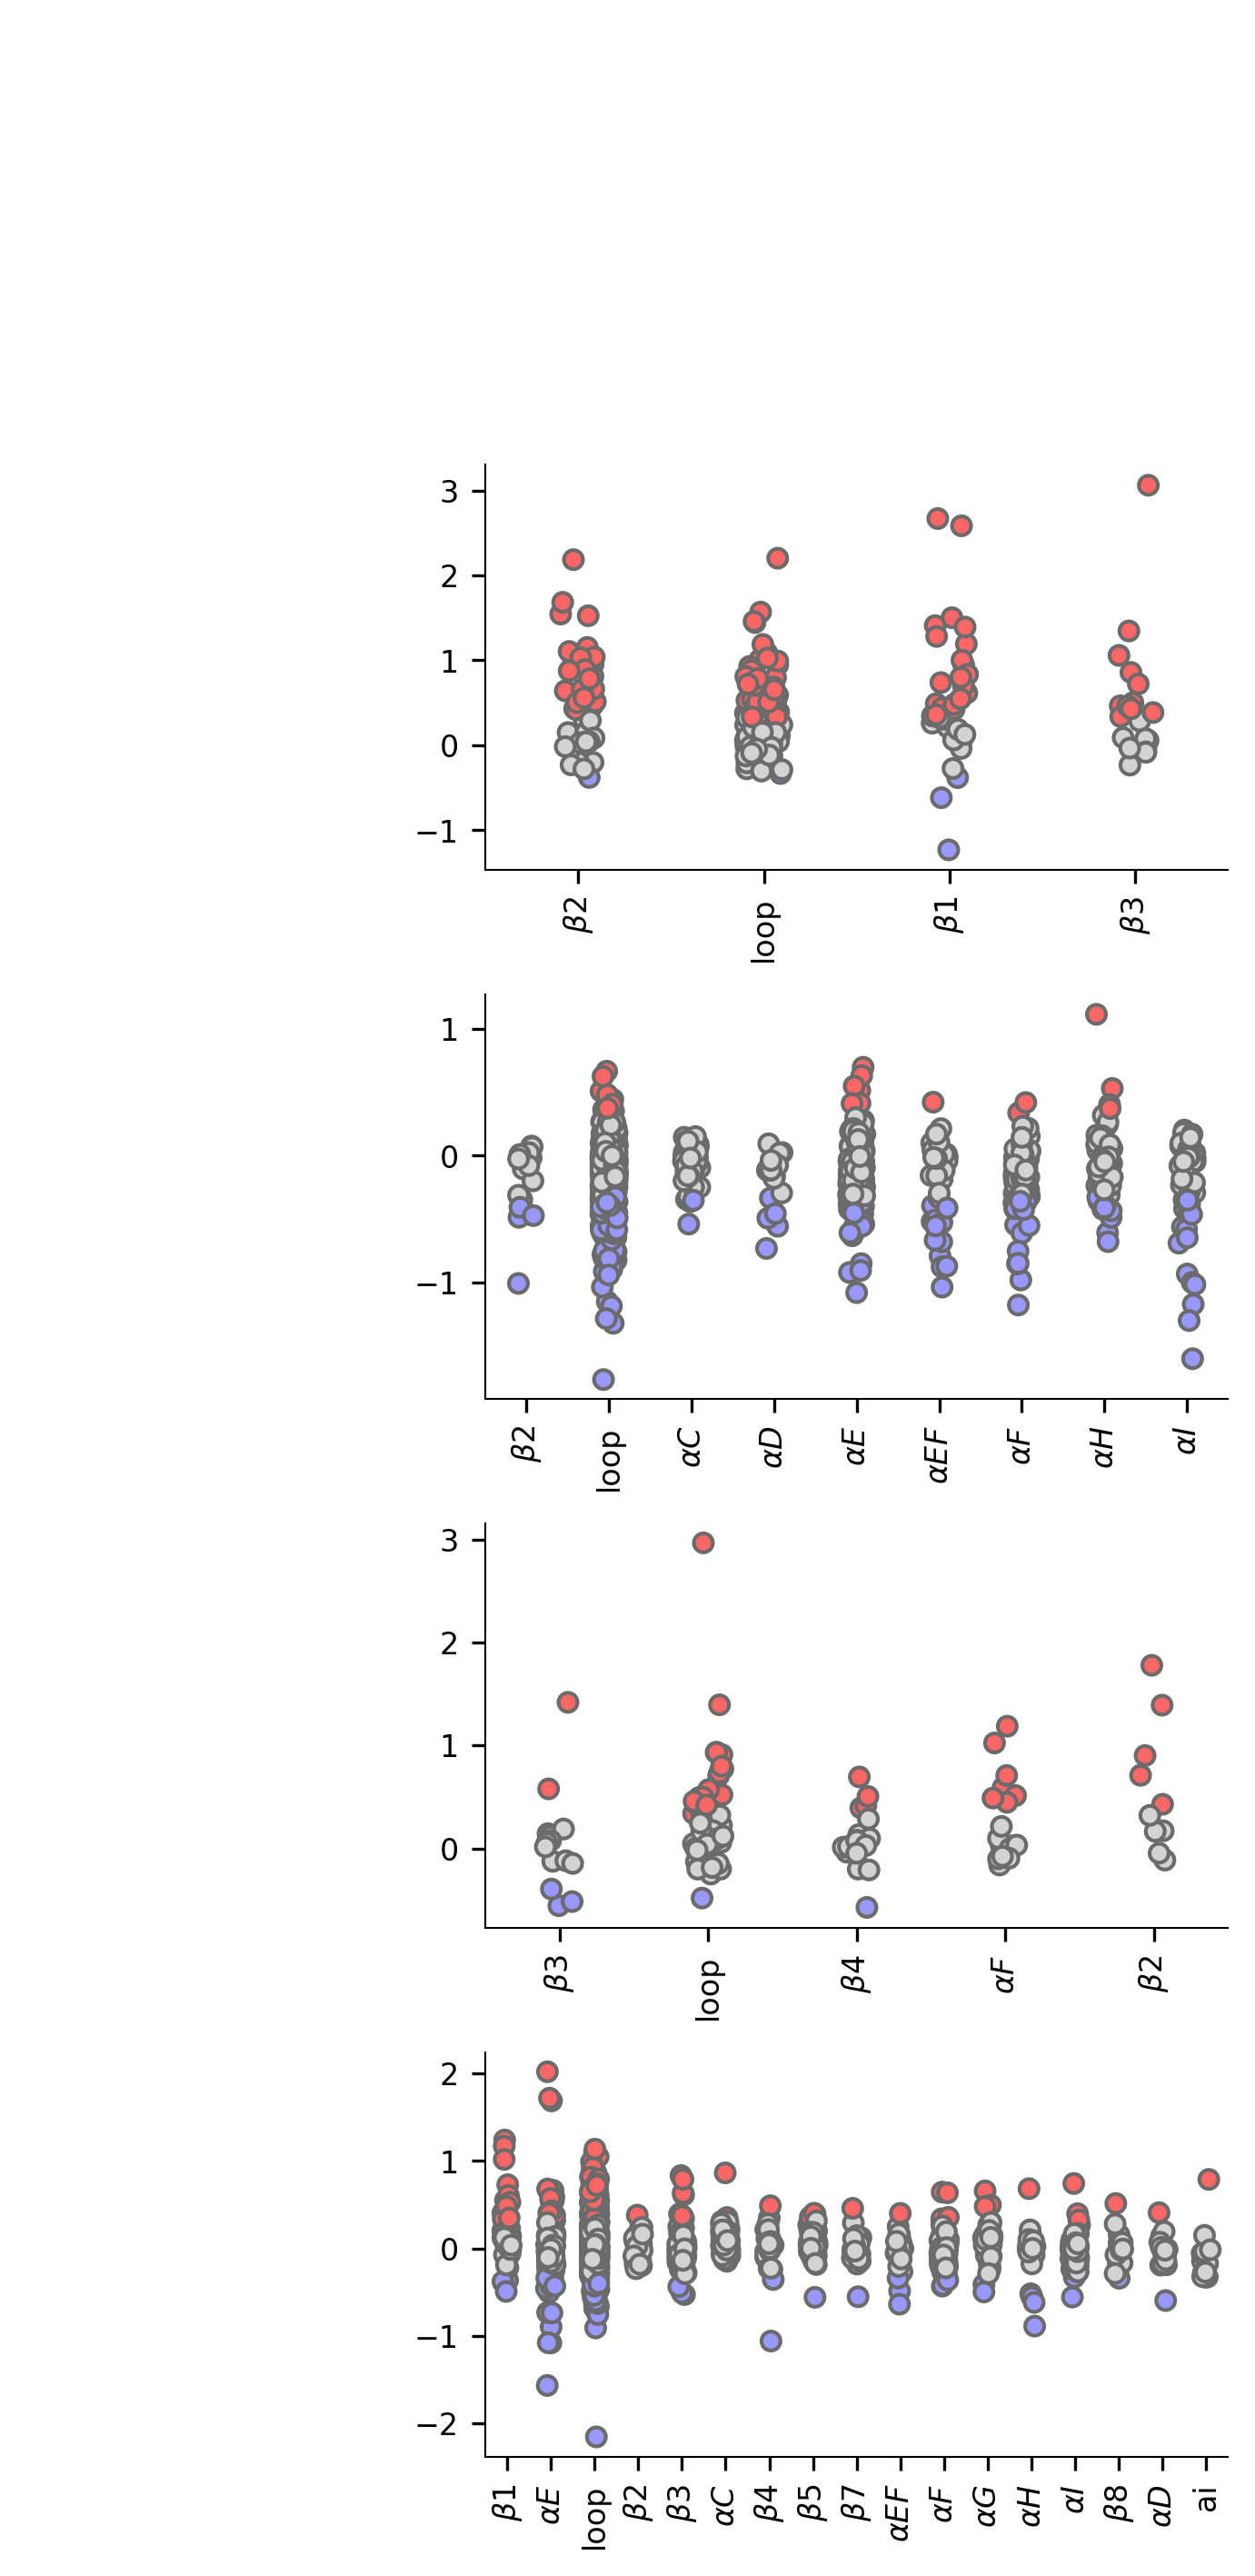

In [679]:
fig4

In [676]:
fig4.savefig('../../Figures/manuscript_figs/fig4_drafts/grid_v1.png')

# Get positions for PyMOL figures

In [677]:
pos_clust_1 = list(np.concatenate((clust_dict[1], clust_dict[2], clust_dict[3], clust_dict[4])))
pos_clust_2 = list(np.concatenate((clust_dict[5], clust_dict[6])))
pos_clust_3 = list(np.concatenate((clust_dict[7], clust_dict[8])))
pos_clust_4 = list(np.concatenate((clust_dict[9], clust_dict[10])))

inv_map = {v: k for k, v in src_utils.__pos_idx_dict__.items()}

# Print PyMOL selection algebra
print('PyMOL selection algebra')
for idx, clust in enumerate([pos_clust_1, pos_clust_2, pos_clust_3, pos_clust_4]):
    selection = 'select clust{}, resi '.format(idx + 1)
    resis = '+'.join([str(inv_map[x]) for x in clust])
    print(selection + resis)
    print('\n')
    
# Print color definitions
print('PyMOL color definitions')
for idx in np.arange(4):
    print('set_color c{}, '.format(idx + 1), list(palette[idx * 2]))
    
# Color clusters according to colors
for idx in np.arange(4):
    print('color c{}, clust{}'.format(idx + 1, idx + 1))

PyMOL selection algebra
select clust1, resi 273+276+286+289+290+291+300+304+413+285+294+274


select clust2, resi 287+299+312+314+315+319+341+345+348+349+351+352+353+354+357+361+363+364+370+371+373+374+375+378+382+392+398+399+400+402+404+415+418+433+440+441+443+445+446+447+448+454+458+462+465+479+488+491+492+494+495+498+500+501+502+503+506+508+510+513+518+323+325+377+397+434+444+504+507+511+512


select clust3, resi 283+297+326+329+331+456+459+335


select clust4, resi 275+372+381+270+271+272+277+278+279+280+281+282+284+288+292+293+295+296+298+301+302+303+305+306+307+308+309+310+311+313+316+317+318+320+321+322+324+327+328+330+332+333+334+336+337+338+339+340+342+343+344+346+347+350+355+356+358+359+360+362+365+366+367+368+369+376+379+380+383+384+385+386+387+388+389+390+391+393+394+395+396+401+403+405+406+407+408+409+410+411+412+414+416+417+419+420+421+422+423+424+425+426+427+428+429+430+431+432+435+436+437+438+439+442+449+450+451+452+453+455+457+460+461+463+464+466+467+468+469+470+471+47

In [678]:
print(list(palette[0]))

[0.86, 0.3712, 0.33999999999999997]


In [650]:
'+'.join([str(inv_map[x]) for x in pos_clust_4])

'275+372+381+270+271+272+277+278+279+280+281+282+284+288+292+293+295+296+298+301+302+303+305+306+307+308+309+310+311+313+316+317+318+320+321+322+324+327+328+330+332+333+334+336+337+338+339+340+342+343+344+346+347+350+355+356+358+359+360+362+365+366+367+368+369+376+379+380+383+384+385+386+387+388+389+390+391+393+394+395+396+401+403+405+406+407+408+409+410+411+412+414+416+417+419+420+421+422+423+424+425+426+427+428+429+430+431+432+435+436+437+438+439+442+449+450+451+452+453+455+457+460+461+463+464+466+467+468+469+470+471+472+473+474+475+476+477+478+480+481+482+483+484+485+486+487+489+490+493+496+497+499+505+509+514+515+516+517+519'

In [651]:
palette[0]

(0.86, 0.3712, 0.33999999999999997)

# Aggregated by amino acid type

In [604]:
cluster = 1 #"""test"""
# Get all elements in cluster
elements = list(set(new_clust_arrs[cluster][0]))

# Get indices for that element
elem_pos_dict = {}
for elem in elements:
    elem_pos_dict[elem] = np.where(np.array(ss_arr) == elem)

# Create empty array for storing element averaged residual scores
num_elements = len(elem_pos_dict.keys())
elem_ave = np.zeros((num_elements, 21))

# Get values from residuals map
for idx, elem, pos in zip(np.arange(len(elem_ave)), elem_pos_dict.keys(), elem_pos_dict.values()):
    pos = pos[0]
    # Get positions corresponding to element
    elem_map = resid_map.values[pos, :]
    # Calculate mean for every amino acid
    elem_map = np.nanmean(elem_map, axis=0)
    
    # Assign averages
    elem_ave[idx, :] = elem_map
    
# Create empty array for aggregation by aa type
num_aa_types = 6
aa_ave = np.zeros((num_elements, num_aa_types))

# Create type dict
aa_type_dict = {
    0: np.arange(0, 3),
    1: np.arange(3, 5),
    2: np.array([5, 7, 8, 9, 10]),
    3: np.array([6, 11, 12, 13, 14]),
    4: np.arange(15, 18),
    5: np.arange(18, 20)
}

# Fill array with averages
for elem in np.arange(num_elements):
    for aa_type in np.arange(num_aa_types):
        type_idx = aa_type_dict[aa_type]
        aa_ave[elem, aa_type] = np.nanmean(elem_ave[elem, type_idx])

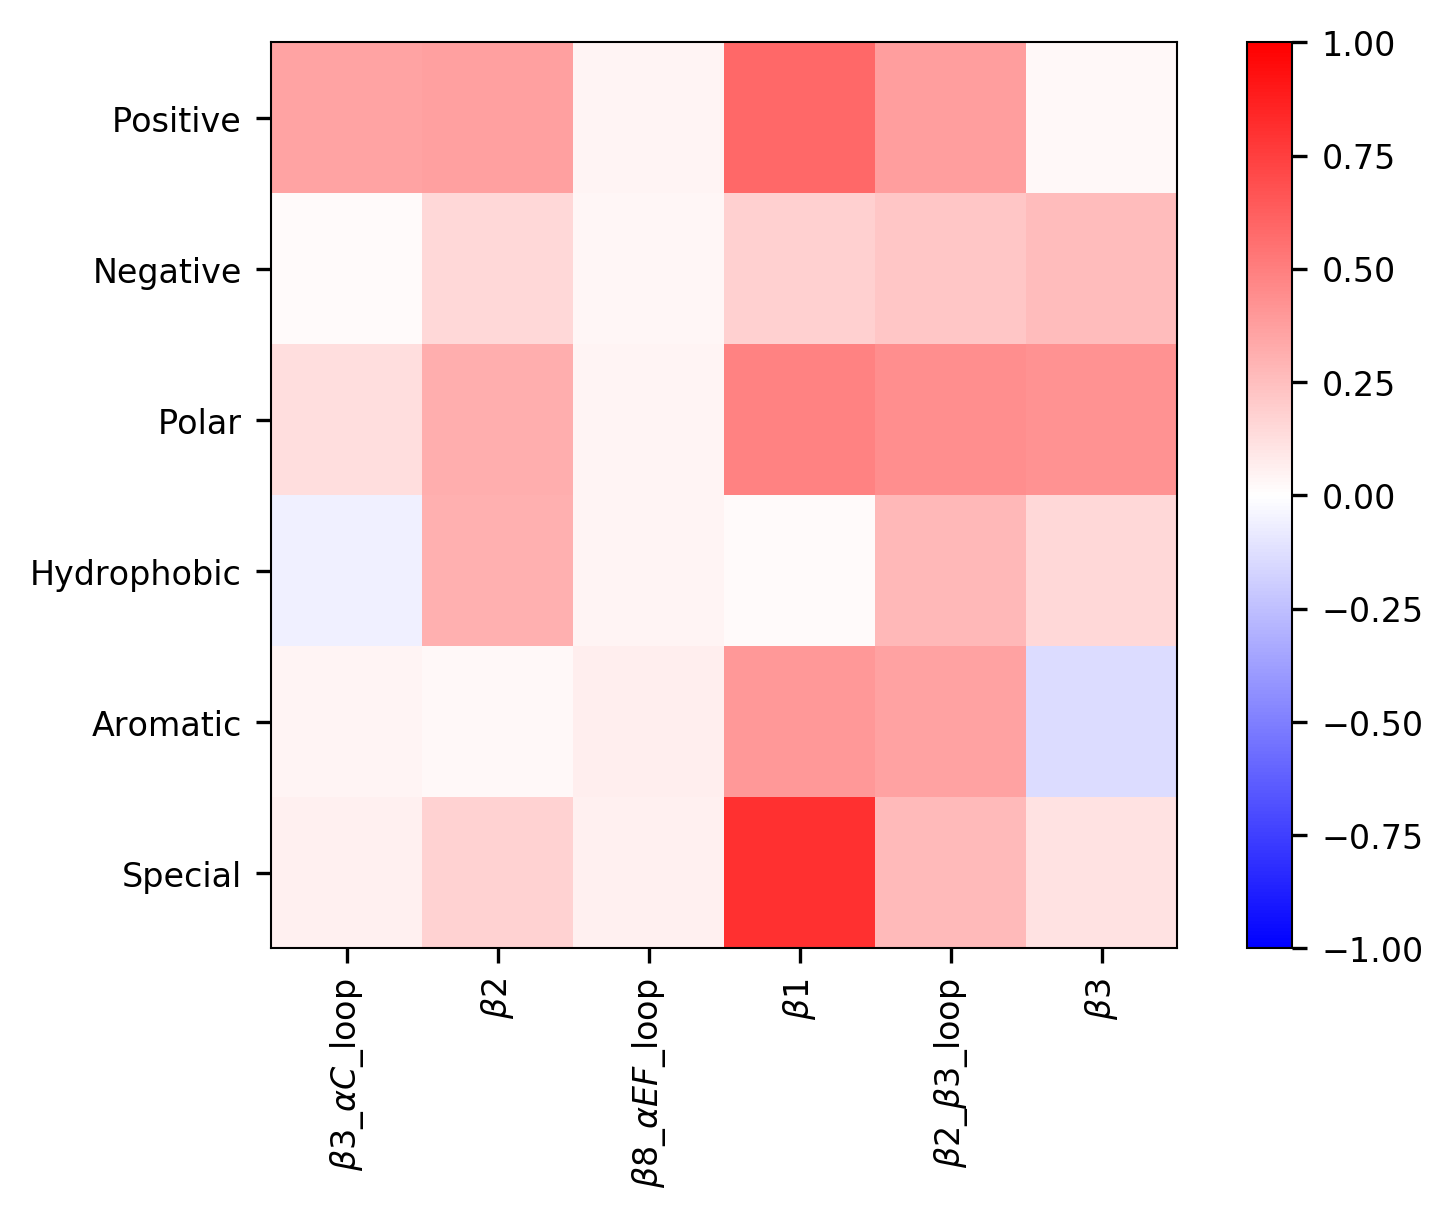

In [605]:
plt.imshow(aa_ave.T, cmap='bwr', vmin=-1, vmax=1)
plt.xticks(np.arange(num_elements), labels=elem_pos_dict.keys(), rotation=90)
plt.yticks(np.arange(num_aa_types), labels=['Positive', 'Negative', 'Polar', 'Hydrophobic', 'Aromatic', 'Special'])
plt.colorbar()

In [608]:
# Get positions
clust_dict

{1: array([  3,   6,  16,  19,  20,  21,  30,  34, 143]),
 2: array([15, 24]),
 3: array([4]),
 4: array([ 17,  29,  42,  44,  45,  49,  71,  75,  78,  79,  81,  82,  83,
         84,  87,  91,  93,  94, 100, 101, 103, 104, 105, 108, 112, 122,
        128, 129, 130, 132, 134, 145, 148, 163, 170, 171, 173, 175, 176,
        177, 178, 184, 188, 192, 195, 209, 218, 221, 222, 224, 225, 228,
        230, 231, 232, 233, 236, 238, 240, 243, 248]),
 5: array([ 53,  55, 107, 127, 164, 174, 234, 237, 241, 242]),
 6: array([ 13,  27,  56,  59,  61,  65, 186, 189]),
 7: array([  5, 102, 111]),
 8: array([  0,   1,   2,   7,   8,   9,  10,  11,  12,  14,  18,  22,  23,
         25,  26,  28,  31,  32,  33,  35,  36,  37,  38,  39,  40,  41,
         43,  46,  47,  48,  50,  51,  52,  54,  57,  58,  60,  62,  63,
         64,  66,  67,  68,  69,  70,  72,  73,  74,  76,  77,  80,  85,
         86,  88,  89,  90,  92,  95,  96,  97,  98,  99, 106, 109, 110,
        113, 114, 115, 116, 117, 118, 119, 

In [519]:
resid_map.values.shape

(250, 21)

In [501]:
a = np.array(['apple', 'orange', 'apple', 'banana'])

arr_index = np.where(a == 'apple')

print(arr_index)

print(a[arr_index])

(array([0, 2]),)
['apple' 'apple']


In [490]:
'$\\beta3$_$\\alpha C$_loop' == elements[0]

True